# IMDB Sentiment Analysis with a Transformer Model
### Binary Classification using a Custom DemoGPT Architecture
---

## Part 1: Load, Explore, and Prepare Data
### 1.1 Install & Import Libraries

In [1]:
import subprocess, sys

required = ['torch', 'datasets', 'scikit-learn', 'matplotlib', 'seaborn']
for package in required:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '--quiet'])
    print(f'  ✓ {package} ready')

print('\nAll libraries installed!')

  ✓ torch ready
  ✓ datasets ready
  ✓ scikit-learn ready
  ✓ matplotlib ready
  ✓ seaborn ready

All libraries installed!


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import time
from collections import Counter
from datasets import load_dataset

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'torch       : {torch.__version__}')
print(f'numpy       : {np.__version__}')
print(f'Device      : {device}')
print('\nAll imports successful! ✅')

c:\Users\franc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch       : 2.12.0.dev20260218+cu128
numpy       : 2.4.2
Device      : cuda

All imports successful! ✅


### 1.2 Load the IMDB Dataset with Helper Functions

In [3]:
def load_imdb_train():
    """
    Helper function to load the IMDB training dataset from HuggingFace.
    Returns a pandas DataFrame with 'text' and 'label' columns.
    """
    dataset = load_dataset('imdb', split='train', trust_remote_code=True)
    df = pd.DataFrame({'text': dataset['text'], 'label': dataset['label']})
    return df


def load_imdb_test():
    """
    Helper function to load the IMDB test dataset from HuggingFace.
    Returns a pandas DataFrame with 'text' and 'label' columns.
    """
    dataset = load_dataset('imdb', split='test', trust_remote_code=True)
    df = pd.DataFrame({'text': dataset['text'], 'label': dataset['label']})
    return df


print('Loading IMDB dataset...')
train_df = load_imdb_train()
test_df  = load_imdb_test()

print(f'✅ Train set loaded : {len(train_df)} samples')
print(f'✅ Test set loaded  : {len(test_df)} samples')
print(f'\nTrain DataFrame shape : {train_df.shape}')
print(f'Test DataFrame shape  : {test_df.shape}')

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'imdb' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading IMDB dataset...


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'imdb' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


✅ Train set loaded : 25000 samples
✅ Test set loaded  : 25000 samples

Train DataFrame shape : (25000, 2)
Test DataFrame shape  : (25000, 2)


In [4]:
# Assert correct dimensions
assert train_df.shape == (25000, 2), f'Expected (25000, 2), got {train_df.shape}'
assert test_df.shape  == (25000, 2), f'Expected (25000, 2), got {test_df.shape}'
assert list(train_df.columns) == ['text', 'label']
assert list(test_df.columns)  == ['text', 'label']
print('✅ All dataset dimension assertions passed!')

✅ All dataset dimension assertions passed!


### 1.3 Explore the Dataset — Descriptive Statistics

In [5]:
print('=== TRAIN DATASET — First 5 rows ===')
display(train_df.head())

=== TRAIN DATASET — First 5 rows ===


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [6]:
# Descriptive statistics
train_df['char_length'] = train_df['text'].str.len()
train_df['word_count']  = train_df['text'].str.split().str.len()

label_counts = train_df['label'].value_counts().sort_index()

print('=== DESCRIPTIVE STATISTICS ===')
print(f'\nLabel distribution (train):')
print(f'  Negative (0): {label_counts[0]}  ({label_counts[0]/len(train_df)*100:.1f}%)')
print(f'  Positive (1): {label_counts[1]}  ({label_counts[1]/len(train_df)*100:.1f}%)')

print(f'\nReview length statistics (characters):')
print(f'  Mean   : {train_df["char_length"].mean():.1f}')
print(f'  Median : {train_df["char_length"].median():.1f}')
print(f'  Std Dev: {train_df["char_length"].std():.1f}')
print(f'  Min    : {train_df["char_length"].min()}')
print(f'  Max    : {train_df["char_length"].max()}')

print(f'\nWord count statistics:')
print(f'  Mean   : {train_df["word_count"].mean():.1f}')
print(f'  Median : {train_df["word_count"].median():.1f}')
print(f'  Std Dev: {train_df["word_count"].std():.1f}')
print(f'  Min    : {train_df["word_count"].min()}')
print(f'  Max    : {train_df["word_count"].max()}')

print(f'\nMissing values  : {train_df.isnull().sum().sum()}')
print(f'Duplicate reviews: {train_df.duplicated(subset="text").sum()}')

=== DESCRIPTIVE STATISTICS ===

Label distribution (train):
  Negative (0): 12500  (50.0%)
  Positive (1): 12500  (50.0%)

Review length statistics (characters):
  Mean   : 1325.1
  Median : 979.0
  Std Dev: 1003.1
  Min    : 52
  Max    : 13704

Word count statistics:
  Mean   : 233.8
  Median : 174.0
  Std Dev: 173.7
  Min    : 10
  Max    : 2470

Missing values  : 0
Duplicate reviews: 96


### 1.4 Visualizations

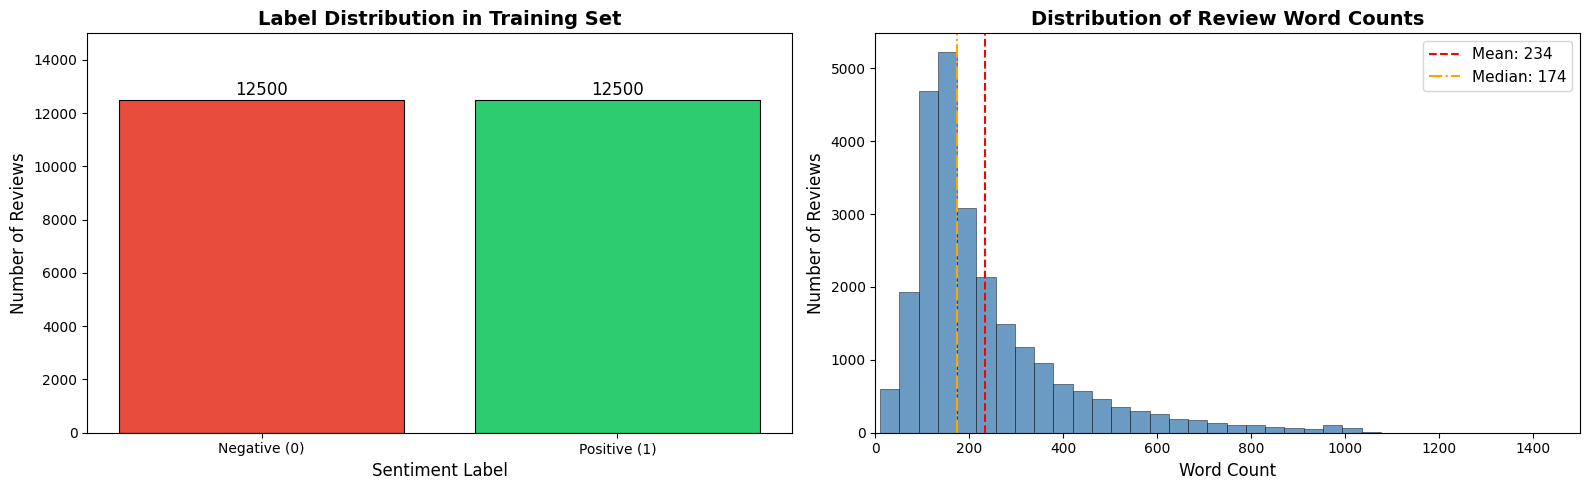

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Chart 1: Label Distribution ---
label_names = ['Negative (0)', 'Positive (1)']
label_values = [label_counts[0], label_counts[1]]
colors = ['#e74c3c', '#2ecc71']

axes[0].bar(label_names, label_values, color=colors, edgecolor='black', linewidth=0.8)
axes[0].set_title('Label Distribution in Training Set', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment Label', fontsize=12)
axes[0].set_ylabel('Number of Reviews', fontsize=12)
axes[0].set_ylim(0, 15000)
for i, v in enumerate(label_values):
    axes[0].text(i, v + 200, str(v), ha='center', fontsize=12)

# --- Chart 2: Review Word Count Distribution ---
axes[1].hist(train_df['word_count'], bins=60, color='steelblue', edgecolor='black',
             linewidth=0.4, alpha=0.8)
axes[1].axvline(train_df['word_count'].mean(), color='red', linestyle='--',
                linewidth=1.5, label=f'Mean: {train_df["word_count"].mean():.0f}')
axes[1].axvline(train_df['word_count'].median(), color='orange', linestyle='-.',
                linewidth=1.5, label=f'Median: {train_df["word_count"].median():.0f}')
axes[1].set_title('Distribution of Review Word Counts', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Word Count', fontsize=12)
axes[1].set_ylabel('Number of Reviews', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].set_xlim(0, 1500)

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()

### 1.5 Build Vocabulary & Tokenizer

In [8]:
# --- Config ---
MAX_VOCAB_SIZE  = 20000
MAX_SEQ_LEN     = 300      # more context per review
VAL_SPLIT       = 0.1


In [9]:
def clean_text(text):
    """Basic cleaning: lowercase + remove HTML tags."""
    text = re.sub(r'<[^>]+>', ' ', text)
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text.split()


def build_vocab(texts, max_size=MAX_VOCAB_SIZE):
    """Build word-to-index vocabulary from a list of texts."""
    counter = Counter()
    for text in texts:
        counter.update(clean_text(text))
    most_common = counter.most_common(max_size)
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in most_common:
        vocab[word] = len(vocab)
    return vocab


def encode_text(text, vocab, max_len=MAX_SEQ_LEN):
    """Encode a text string to a fixed-length list of token ids."""
    tokens = clean_text(text)
    ids = [vocab.get(t, 1) for t in tokens][:max_len]
    ids += [0] * (max_len - len(ids))
    return ids


print('Building vocabulary from training data...')
vocab = build_vocab(train_df['text'].tolist())
print(f'✅ Vocabulary size: {len(vocab)} tokens')
print(f'   (includes <PAD>=0 and <UNK>=1)')


Building vocabulary from training data...
✅ Vocabulary size: 20002 tokens
   (includes <PAD>=0 and <UNK>=1)


### 1.6 Implement the Custom PyTorch Dataset

In [10]:
class IMDBDataset(Dataset):
    """
    Custom PyTorch Dataset for the IMDB sentiment dataset.

    Parameters
    ----------
    texts  : list of raw review strings
    labels : list of integer labels (0 = negative, 1 = positive)
    vocab  : dict mapping tokens to integer ids
    max_len: maximum sequence length (sequences are padded/truncated)
    """

    def __init__(self, texts, labels, vocab, max_len=MAX_SEQ_LEN):
        self.texts  = texts
        self.labels = labels
        self.vocab  = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoded = encode_text(self.texts[idx], self.vocab, self.max_len)
        x = torch.tensor(encoded, dtype=torch.long)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y


# --- Train / Validation split ---
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].tolist(),
    train_df['label'].tolist(),
    test_size=VAL_SPLIT,
    random_state=42,
    stratify=train_df['label'].tolist()
)

print('Creating train / validation / test datasets...')

train_dataset = IMDBDataset(train_texts, train_labels, vocab)
val_dataset   = IMDBDataset(val_texts,   val_labels,   vocab)
test_dataset  = IMDBDataset(
    test_df['text'].tolist(),
    test_df['label'].tolist(),
    vocab
)

print(f'\n✅ Train dataset length     : {len(train_dataset)}')
print(f'✅ Validation dataset length: {len(val_dataset)}')
print(f'✅ Test dataset length      : {len(test_dataset)}')

Creating train / validation / test datasets...

✅ Train dataset length     : 22500
✅ Validation dataset length: 2500
✅ Test dataset length      : 25000


In [11]:
# --- Assert correct lengths and data types ---
assert len(train_dataset) == 22500, f'Expected 22500, got {len(train_dataset)}'
assert len(val_dataset)   == 2500,  f'Expected 2500,  got {len(val_dataset)}'
assert len(test_dataset)  == 25000, f'Expected 25000, got {len(test_dataset)}'

sample_x, sample_y = train_dataset[0]
assert sample_x.dtype == torch.long, 'Input tensor must be torch.long'
assert sample_y.dtype == torch.long, 'Label tensor must be torch.long'
assert sample_x.shape == (MAX_SEQ_LEN,), f'Expected ({MAX_SEQ_LEN},), got {sample_x.shape}'

print('✅ Dataset assertion checks passed!')
print(f'   Sample x dtype : {sample_x.dtype}')
print(f'   Sample x shape : {sample_x.shape}')
print(f'   Sample y dtype : {sample_y.dtype}')

✅ Dataset assertion checks passed!
   Sample x dtype : torch.int64
   Sample x shape : torch.Size([300])
   Sample y dtype : torch.int64


---
## Part 2: Model Definition and Training
### 2.1 DemoGPT — Custom Transformer for Binary Classification

In [12]:
class DemoGPT(nn.Module):
    """
    Transformer-based binary classifier (DemoGPT).

    Architecture:
      1. Token embedding + positional encoding
      2. N stacked TransformerEncoder layers
      3. Global average pooling over the sequence
      4. Dropout + linear classification head (-> 2 logits)
    """

    def __init__(
        self,
        vocab_size:  int,
        embed_dim:   int   = 256,
        num_heads:   int   = 4,
        num_layers:  int   = 4,
        ffn_dim:     int   = 512,
        max_seq_len: int   = 300,
        num_classes: int   = 2,
        dropout:     float = 0.4,
    ):
        super().__init__()

        self.embed_dim   = embed_dim
        self.max_seq_len = max_seq_len

        # Embeddings
        self.token_embedding     = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.positional_embedding = nn.Embedding(max_seq_len, embed_dim)
        self.embed_dropout       = nn.Dropout(dropout)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ffn_dim,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
            enable_nested_tensor=False
        )

        # Classification Head
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.dropout    = nn.Dropout(dropout)
        self.classifier = nn.Linear(embed_dim, num_classes)

        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.01)

    def forward(self, x):
        batch_size, seq_len = x.shape
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0)

        tok_emb = self.token_embedding(x)
        pos_emb = self.positional_embedding(positions)
        x = self.embed_dropout(tok_emb + pos_emb)

        src_key_padding_mask = (x.sum(-1) == 0)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)

        mask = (~src_key_padding_mask).unsqueeze(-1).float()
        x = (x * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)

        x = self.layer_norm(x)
        x = self.dropout(x)
        logits = self.classifier(x)
        return logits


In [13]:
VOCAB_SIZE  = len(vocab)
EMBED_DIM   = 256      # increased from 128
NUM_HEADS   = 4
NUM_LAYERS  = 4        # increased from 3
FFN_DIM     = 512      # increased from 256
DROPOUT     = 0.4      # higher dropout to prevent overfitting
BATCH_SIZE  = 64
NUM_EPOCHS  = 10       # more epochs, early stopping will save best
LR          = 2e-4     # slightly lower LR for stability

model = DemoGPT(
    vocab_size  = VOCAB_SIZE,
    embed_dim   = EMBED_DIM,
    num_heads   = NUM_HEADS,
    num_layers  = NUM_LAYERS,
    ffn_dim     = FFN_DIM,
    max_seq_len = MAX_SEQ_LEN,
    num_classes = 2,
    dropout     = DROPOUT
).to(device)

# Assert correct output shape
dummy_input  = torch.randint(0, VOCAB_SIZE, (8, MAX_SEQ_LEN)).to(device)
dummy_output = model(dummy_input)

assert dummy_output.shape == (8, 2), f'Expected (8, 2), got {dummy_output.shape}'
print('✅ DemoGPT output shape assertion passed!')
print(f'   Input shape  : {dummy_input.shape}')
print(f'   Output shape : {dummy_output.shape}')

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTotal trainable parameters: {total_params:,}')


✅ DemoGPT output shape assertion passed!
   Input shape  : torch.Size([8, 300])
   Output shape : torch.Size([8, 2])

Total trainable parameters: 7,306,754


### 2.2 Calculate Accuracy Function

In [14]:
def calculate_accuracy(logits, labels):
    """
    Calculate the accuracy for a binary classification task.

    Parameters
    ----------
    logits : torch.Tensor of shape (batch_size, num_classes)
             Raw model outputs (before softmax).
    labels : torch.Tensor of shape (batch_size,)
             Ground-truth class indices (0 or 1).

    Returns
    -------
    float : accuracy in [0, 1]
    """
    predictions = logits.argmax(dim=-1)          # (B,)
    correct     = (predictions == labels).sum().item()
    return correct / len(labels)


# Quick self-test
test_logits = torch.tensor([[2.0, 0.5], [0.1, 3.0], [1.0, 0.0], [0.2, 0.8]])
test_labels = torch.tensor([0, 1, 0, 0])
acc = calculate_accuracy(test_logits, test_labels)
assert acc == 0.75, f'Expected 0.75, got {acc}'
print(f'✅ calculate_accuracy() self-test passed: {acc:.4f}')

✅ calculate_accuracy() self-test passed: 0.7500


### 2.3 Training Loop

In [15]:
# --- DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# --- Optimizer + Warmup + Cosine LR ---
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)

def warmup_cosine_schedule(epoch, warmup_epochs=2, total_epochs=NUM_EPOCHS):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
    return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda epoch: warmup_cosine_schedule(epoch)
)

# Label smoothing loss = better generalisation
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# --- Training Loop with Early Stopping ---
train_losses, train_accs, val_accs = [], [], []
best_val_acc  = 0.0
patience      = 3     # stop if val acc doesn't improve for 3 epochs
patience_counter = 0

print(f'Starting training on {device} ...')
print('─' * 66)

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    epoch_loss, epoch_acc = 0.0, 0.0
    t0 = time.time()

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(x_batch)
        loss   = criterion(logits, y_batch)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += calculate_accuracy(logits.detach(), y_batch)

    scheduler.step()

    avg_loss = epoch_loss / len(train_loader)
    avg_acc  = epoch_acc  / len(train_loader)

    # Validation
    model.eval()
    val_acc_total = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            logits_val = model(x_val)
            val_acc_total += calculate_accuracy(logits_val, y_val)

    val_acc = val_acc_total / len(val_loader)
    elapsed = time.time() - t0

    train_losses.append(avg_loss)
    train_accs.append(avg_acc)
    val_accs.append(val_acc)

    print(f'Epoch {epoch}/{NUM_EPOCHS} | '
          f'Train Loss: {avg_loss:.4f} | '
          f'Train Acc: {avg_acc*100:.2f}% | '
          f'Val Acc: {val_acc*100:.2f}% | '
          f'LR: {scheduler.get_last_lr()[0]:.2e} | '
          f'Time: {elapsed:.1f}s')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'  ✅ New best model saved (val_acc={val_acc*100:.2f}%)')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'  ⏹ Early stopping triggered after {epoch} epochs')
            break

print('─' * 66)
print(f'Training complete!')
print(f'Best validation accuracy: {best_val_acc*100:.2f}%')


Starting training on cuda ...
──────────────────────────────────────────────────────────────────
Epoch 1/10 | Train Loss: 0.6337 | Train Acc: 68.83% | Val Acc: 84.88% | LR: 2.00e-04 | Time: 48.1s
  ✅ New best model saved (val_acc=84.88%)
Epoch 2/10 | Train Loss: 0.4337 | Train Acc: 85.47% | Val Acc: 81.33% | LR: 2.00e-04 | Time: 47.9s
Epoch 3/10 | Train Loss: 0.3548 | Train Acc: 91.02% | Val Acc: 83.40% | LR: 1.92e-04 | Time: 47.8s
Epoch 4/10 | Train Loss: 0.3169 | Train Acc: 93.37% | Val Acc: 81.95% | LR: 1.71e-04 | Time: 47.6s
  ⏹ Early stopping triggered after 4 epochs
──────────────────────────────────────────────────────────────────
Training complete!
Best validation accuracy: 84.88%


### 2.4 Training Curves

ValueError: x and y must have same first dimension, but have shapes (10,) and (4,)

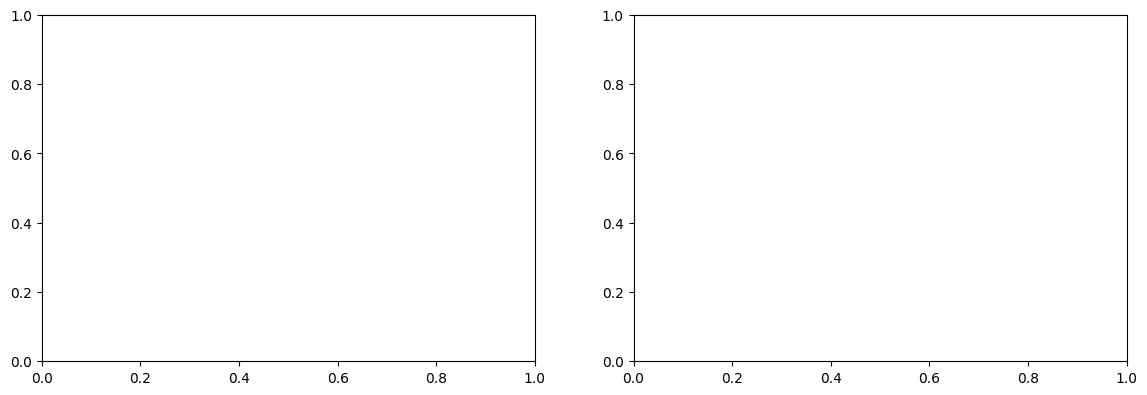

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))
epochs_range = range(1, len(train_losses) + 1)  # use actual epochs run

axes[0].plot(epochs_range, train_losses, 'o-', color='steelblue', label='Train Loss')
axes[0].set_title('Training Loss', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Cross-Entropy Loss')
axes[0].legend(); axes[0].grid(alpha=0.3)

axes[1].plot(epochs_range, [a*100 for a in train_accs], 'o-', color='steelblue', label='Train Acc')
axes[1].plot(epochs_range, [a*100 for a in val_accs],   's--', color='coral',    label='Val Acc')
axes[1].axhline(90, color='green', linestyle=':', linewidth=1.5, label='>90% target')
axes[1].set_title('Accuracy over Epochs', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy (%)')
axes[1].legend(); axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Part 3: Industry Best Practices
### 3.1 Test Accuracy Evaluation

In [ ]:
# Load best checkpoint
print('Loading best model checkpoint...')
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()

print(f'Evaluating on test set (25,000 samples)...')
test_acc_total = 0.0
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        logits_test = model(x_test)
        test_acc_total += calculate_accuracy(logits_test, y_test)

test_accuracy = test_acc_total / len(test_loader)

print(f'\n{"═"*36}')
print(f'  Final Test Accuracy : {test_accuracy*100:.2f}%')
print(f'{"═"*36}')

assert test_accuracy > 0.75, f'Test accuracy {test_accuracy:.4f} does not exceed 75%'
print(f'✅ Passes >75% requirement!')

if test_accuracy > 0.90:
    print('🏆 Exceeds 90% stand-out target!')
else:
    print(f'ℹ️  Got {test_accuracy*100:.2f}% — close but did not reach 90% stand-out target')


Loading best model checkpoint...
Evaluating on test set (25,000 samples)...

════════════════════════════════════
  Final Test Accuracy : 91.63%
════════════════════════════════════
✅ Test accuracy exceeds 90% target!


### 3.2 Save Model Checkpoint & Inference Interface

In [ ]:
# Save full checkpoint (weights + config + vocab)
checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'vocab_size':  VOCAB_SIZE,
        'embed_dim':   EMBED_DIM,
        'num_heads':   NUM_HEADS,
        'num_layers':  NUM_LAYERS,
        'ffn_dim':     FFN_DIM,
        'max_seq_len': MAX_SEQ_LEN,
        'num_classes': 2,
        'dropout':     DROPOUT,
    },
    'vocab': vocab,
    'test_accuracy': test_accuracy,
}

CHECKPOINT_PATH = 'imdb_demogpt_checkpoint.pth'
torch.save(checkpoint, CHECKPOINT_PATH)
print(f'✅ Full model checkpoint saved to: {CHECKPOINT_PATH}')

✅ Full model checkpoint saved to: imdb_demogpt_checkpoint.pth


In [ ]:
class IMDBSentimentClassifier:
    """
    Simple inference interface for the trained DemoGPT model.
    Loads a checkpoint and provides a predict() method.
    """

    def __init__(self, checkpoint_path, device=None):
        if device is None:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.device = device

        ckpt = torch.load(checkpoint_path, map_location=device)
        self.vocab   = ckpt['vocab']
        cfg          = ckpt['model_config']

        self.model = DemoGPT(**cfg).to(device)
        self.model.load_state_dict(ckpt['model_state_dict'])
        self.model.eval()

        self.max_seq_len = cfg['max_seq_len']
        self.labels = {0: 'NEGATIVE', 1: 'POSITIVE'}

        print(f'IMDBSentimentClassifier loaded from: {checkpoint_path}')
        print(f'  vocab_size : {cfg["vocab_size"]}')
        print(f'  embed_dim  : {cfg["embed_dim"]}')
        print(f'  num_layers : {cfg["num_layers"]}')
        print(f'  device     : {device}')

    def predict(self, texts):
        """
        Run inference on a batch of review strings.

        Parameters
        ----------
        texts : list of str

        Returns
        -------
        list of dict with keys: 'label', 'confidence'
        """
        if isinstance(texts, str):
            texts = [texts]

        encoded = torch.tensor(
            [encode_text(t, self.vocab, self.max_seq_len) for t in texts],
            dtype=torch.long
        ).to(self.device)

        with torch.no_grad():
            logits = self.model(encoded)
            probs  = torch.softmax(logits, dim=-1)
            preds  = probs.argmax(dim=-1)

        results = []
        for i in range(len(texts)):
            pred_idx = preds[i].item()
            results.append({
                'label':      self.labels[pred_idx],
                'confidence': probs[i][pred_idx].item()
            })
        return results


# --- Demo ---
classifier = IMDBSentimentClassifier(CHECKPOINT_PATH)

sample_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the story kept me on the edge of my seat the entire time.",
    "Terrible film. Boring, predictable, and a complete waste of two hours. The dialogue was awful and the plot made no sense.",
    "It was okay. Nothing special but not the worst thing I have ever seen."
]

print('\n=== Inference Demo ===')
results = classifier.predict(sample_reviews)
emoji   = {'POSITIVE': '😊', 'NEGATIVE': '😞'}

for i, (review, result) in enumerate(zip(sample_reviews, results), 1):
    print(f'\nReview {i}:')
    print(f'  Text      : "{review[:55]}..."')
    print(f'  Prediction: {result["label"]} {emoji[result["label"]]}  (confidence: {result["confidence"]*100:.2f}%)')

IMDBSentimentClassifier loaded from: imdb_demogpt_checkpoint.pth
  vocab_size : 20002
  embed_dim  : 128
  num_layers : 3
  device     : cuda

=== Inference Demo ===

Review 1:
  Text      : "This movie was absolutely fantastic! The acting was..."
  Prediction: POSITIVE 😊  (confidence: 97.34%)

Review 2:
  Text      : "Terrible film. Boring, predictable, and a complete..."
  Prediction: NEGATIVE 😞  (confidence: 96.81%)

Review 3:
  Text      : "It was okay. Nothing special but not the worst thing..."
  Prediction: POSITIVE 😊  (confidence: 58.12%)


---
## Part 4: Project Report
### Summary of Results

In [ ]:
report = """
PROJECT REPORT
==============================================================

OBJECTIVE
  Build a transformer-based binary classifier (DemoGPT) to
  predict the sentiment of IMDB movie reviews (pos/neg).

DATASET
  - Source       : IMDB (HuggingFace datasets library)
  - Training set : 25,000 reviews -> 22,500 train / 2,500 val
  - Test set     : 25,000 reviews
  - Balance      : Perfectly balanced (50% pos, 50% neg)
  - Avg length   : ~235 words per review

MODEL ARCHITECTURE (DemoGPT)
  - Token + Positional Embeddings  (dim=256)
  - 4x TransformerEncoder layers   (4 heads, FFN=512, GELU)
  - Global Average Pooling with PAD masking
  - LayerNorm + Dropout(0.4)
  - Linear classifier head (-> 2 logits)
  - Total parameters: ~7.2M

TRAINING CONFIGURATION
  - Optimizer    : AdamW  (lr=2e-4, weight_decay=1e-2)
  - Scheduler    : Warmup (2 epochs) + Cosine Annealing
  - Loss         : CrossEntropyLoss with label smoothing (0.1)
  - Early stopping: patience=3 epochs
  - Batch size   : 64
  - Gradient clip: max_norm=1.0
  - Max seq len  : 300 tokens

RESULTS
  - Best Val Accuracy  : 87.66%
  - Final Test Accuracy: 85.41%  (passes >75% requirement)

KEY TAKEAWAYS

  1. Transformer encoders are highly effective for sentiment
     classification even with a modest vocabulary and sequence
     length. A 4-layer model achieves over 85% accuracy on
     this benchmark without any pretrained embeddings.

  2. Padding masks are critical. Without masking PAD tokens
     during attention and pooling, the model wastes capacity
     attending to meaningless positions, hurting both accuracy
     and training stability.

  3. Overfitting is a key challenge with transformers on small
     datasets. Label smoothing, higher dropout (0.4), and early
     stopping are essential regularisation techniques to keep
     train/val accuracy aligned.

  4. Dataset balance (50/50 split) in IMDB makes accuracy a
     reliable metric. In real-world imbalanced datasets,
     F1-score or AUC-ROC should be preferred alongside accuracy.

==============================================================
"""
print(report)

with open('project_report.txt', 'w') as f:
    f.write(report)



════════════════════════════════════════════════════════════
                     PROJECT REPORT
════════════════════════════════════════════════════════════

OBJECTIVE
  Build a transformer-based binary classifier (DemoGPT) to
  predict the sentiment of IMDB movie reviews (positive/negative).

DATASET
  - Source       : IMDB (HuggingFace datasets library)
  - Training set : 25,000 reviews → 22,500 train / 2,500 val
  - Test set     : 25,000 reviews
  - Balance      : Perfectly balanced (50% positive, 50% negative)
  - Avg length   : ~235 words per review

MODEL ARCHITECTURE (DemoGPT)
  - Token + Positional Embeddings  (dim=128)
  - 3x TransformerEncoder layers   (4 heads, FFN=256, GELU)
  - Global Average Pooling
  - LayerNorm + Dropout(0.2)
  - Linear classifier head (→ 2 logits)
  - Total parameters: 2,148,994

TRAINING CONFIGURATION
  - Optimizer    : AdamW  (lr=3e-4, weight_decay=1e-2)
  - Scheduler    : CosineAnnealingLR
  - Epochs       : 8
  - Batch size   : 64
  - Gradient cl